# Load in Data
---



In [ ]:
'''
SECTION: CONNECT TO GOOGLE DRIVE

Purpose:
-Mount the Google Drive

'''

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
SECTION: LOAD DATA

Purpose:
-Install packages to read CSV files in

'''

import pandas as pd

# Replace with the actual path to your file
file_path = '/content/drive/MyDrive/[USE] Updated RAI Measures May 20.xlsx'

# Load the CSV file
full_df = pd.read_excel(file_path)

# display(full_df)

In [ ]:
'''
SECTION: INSPECT

Purpose:
-Inspect and sanity test the dataframe

'''

# full_df.head()
# full_df.shape
# full_df.head(5)
# full_df.columns
# full_df.head(3)

'\nSECTION: INSPECT\n\nPurpose:\n-Inspect and sanity test the dataframe\n\n'

# Dataset Cleaning

---



## Drop Irrelevant Columns and Rename

In [ ]:
'''
SECTION: DROP COLUMNS

Purpose:
-Drop irrelevant columns for the final dataset

'''

dropped_df = full_df.drop(["Paper? ", "Reviewer", "Covidence #","Study ID", "Reviewer Name","Principle (self-identified in paper)", "Principle (coded by Research Assistant)", "Principle (coded by RS + SR)", "Application area (original)", "Measurement process (full)", "Type of assessment (original)", "Part of the ML system (original)", "Notes", "Attribute/Dimension", "Hazard", "Primary Harm", "Secondary Harm",
       "Observations about how it signals this harm"], axis=1)
dropped_df.columns

Index(['Title', 'Link', 'Lead author', 'Year of publication', 'Key contributions', 'Principle category-based', 'Purpose of machine learning system', 'Machine learning algorithm', 'Type of data', 'Application area', 'Part of the ML system', 'Stated Criterion', 'Stated criterion definition (according to paper)', 'Measure', 'Measurement process (short)', 'Type of assessment'], dtype='object')

In [ ]:
'''
SECTION: RENAME COLUMNS

Purpose:
-Rename the dataset columns appropriately

'''
#Rename columns
dropped_df.rename(columns={"Lead author" : "Lead Author(s)",'Year of publication': 'Publication Year', 'Principle category-based': 'Principle', "Key contributions" : "Key Contributions", "Purpose of machine learning system" : "Purpose of ML System", "Machine learning algorithm" : "Algorithm Type", "Type of data" : "Type of Data", "Application area" : "Application Area", "Part of the ML system" : "Component of the ML System", "Stated Criterion" : "Criterion Name", "Stated criterion definition (according to paper)" : "Criterion Description", "Measurement process (short)" : "Measurement Process", "Type of assessment" : "Type of Assessment"}, inplace=True)

#Change publication year to be a whole number
dropped_df['Publication Year'] = pd.to_numeric(dropped_df['Publication Year'], errors='coerce').astype('Int64')

#Sanity test remaining columns
dropped_df.columns

Index(['Title', 'Link', 'Lead Author(s)', 'Publication Year', 'Key Contributions', 'Principle', 'Purpose of ML System', 'Algorithm Type', 'Type of Data', 'Application Area', 'Component of the ML System', 'Criterion Name', 'Criterion Description', 'Measure', 'Measurement Process', 'Type of Assessment'], dtype='object')

In [ ]:
# dropped_df.head()

In [ ]:
'''
SECTION: N/A Values

Purpose:
-Count the number of N/A values

'''

#Count the total number of rows in the dataset
###TEST: CONFIRMED IN SPREADSHEET ###

total_rows = len(dropped_df)
print(f"Total number of rows in the dataset: {total_rows}")

#Count NaN values in each column
###TEST: CONFIRMED - STATED CRITERION AND SECONDARY HARMS HAVE EMPTY CELLS / DOES APPEAR SPREADSHEET ###

nan_counts = dropped_df.isna().sum()
# print(f"Each row's count of NaN rows:\n {nan_counts}")

nan_percentage = (nan_counts / total_rows) * 100
# print(f"Each row's percentage of NaN rows:\n {nan_percentage}")

#Display NaN counts and percentages
nan_summary = pd.DataFrame({'NaN Count': nan_counts, 'Percentage (%)': nan_percentage})
# display(nan_summary)


Total number of rows in the dataset: 791


In [ ]:
'''
SECTION: REORDER COLUMNS

Purpose:
-Reorder the dataset columns appropriately

'''

new_order = [
    'Measure', 'Measurement Process', 'Principle', 'Component of the ML System',
    'Criterion Name', 'Criterion Description', 'Type of Assessment',
    'Application Area', 'Purpose of ML System', 'Type of Data',
    'Algorithm Type', 'Title', 'Lead Author(s)', 'Publication Year', 'Key Contributions'
]

#Reorder columns
dropped_df = dropped_df[new_order]

# display(dropped_df)

In [ ]:
'''
SECTION: CAPITALIZING THE MEASURES

Purpose:
-Inspect unique cell values
-Will remain commented out as output is lengthy

'''

#Convert lists to strings, capitalize each word
dropped_df['Measure'] = dropped_df['Measure'].apply(
    lambda x: ', '.join([i.title() for i in x]) if isinstance(x, list) else str(x).title()
)

# display(dropped_df)


/tmp/ipython-input-495-1141622945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_df['Measure'] = dropped_df['Measure'].apply(


In [ ]:
'''
SECTION: DEBUGGING UNIQUE ASSESSMENT TYPES

Purpose:
- Identify and resolve overcounting issues in the analysis of assessment types
'''

# Step 1: Remove duplicate rows from the original DataFrame
dropped_df_ta = dropped_df.drop_duplicates()

# Step 2: Split 'Type of Assessment' column by commas to handle multiple entries
dropped_df_ta['Type of Assessment'] = dropped_df_ta['Type of Assessment'].str.split(',')

# Step 3: Clean up spaces and lowercase each part after splitting
dropped_df_ta['Type of Assessment'] = dropped_df_ta['Type of Assessment'].apply(
    lambda x: [item.strip().lower() for item in x] if isinstance(x, list) else x
)

# Step 4: Explode the 'Type of Assessment' column
dropped_df_ta_ex = dropped_df_ta.explode('Type of Assessment')

# Debugging: Check for unexpected values
print("Unique values after cleanup:", dropped_df_ta_ex['Type of Assessment'].unique())

# Step 5: Count occurrences of each unique type of assessment
ta_counts = dropped_df_ta_ex['Type of Assessment'].value_counts().reset_index()
ta_counts.columns = ['Type of Assessment', 'Count']

# Debugging: Print row counts before and after processing
print(f"Rows before splitting: {len(dropped_df_ta)}")
print(f"Rows after exploding: {len(dropped_df_ta_ex)}")

# Step 6: Calculate percentages
total_ta = len(dropped_df_ta_ex)
ta_counts['Percentage'] = (ta_counts['Count'] / total_ta) * 100

# Debugging: Compare totals
print(f"Total count from code: {total_ta}")
print(f"Manual total count: 794")

# Display results
display(ta_counts)


Unique values after cleanup: ['mathematical' 'statistical' 'behavioural' 'self-reported']
Rows before splitting: 791
Rows after exploding: 794
Total count from code: 794
Manual total count: 794


,Type of Assessment,Count,Percentage
0,mathematical,315,39.672544
1,statistical,291,36.649874
2,self-reported,137,17.254408
3,behavioural,51,6.423174


# Export spreadsheet

In [ ]:
file_path = "RAI_Measures_Cleaned Dec 19.xlsx"  # Specify your file path
dropped_df.to_excel(file_path, index=False)  # index=False prevents exporting the index as a column

print(f"DataFrame exported to {file_path}")

DataFrame exported to RAI_Measures_Cleaned Dec 19.xlsx


# Descriptive Statistics

---


## Principles




In [ ]:
'''
SECTION: NON-EXPLODED PRINCIPLES E.G. FAIRNESS + TRANSPARENCY

Purpose:
-Inspect the count of all principles and their combinations e.g. fairness and transparency

'''

dropped_df_principle = dropped_df.copy()

dropped_df_principle['Principle'] = dropped_df_principle['Principle'].str.strip()

#Count occurrences of each unique value (including lists of several, combined principles)

### TEST: CONFIRMED SOLIDARITY AND BENEFICENCE COUNTS MANUALLY ###
principle_counts_all = dropped_df_principle['Principle'].value_counts(dropna=False)

#Calculate the percentage
total = len(dropped_df_principle)
principle_percentage = (principle_counts_all / total) * 100

principle_result = pd.DataFrame({
    'Count': principle_counts_all,
    'Percentage': principle_percentage
})

display(principle_result)

#Find rows with NaN values
nan_rows = dropped_df_principle[dropped_df_principle['Principle'].isna()].index.tolist()

empty_row = dropped_df.loc[dropped_df_principle['Principle'].isna()]
empty_row

#CORRECT

,Count,Percentage
Principle,,
Fairness,357,45.132743
Transparency,157,19.848293
Privacy,103,13.021492
Trust,82,10.366625
Sustainability,17,2.149178
Freedom and autonomy,17,2.149178
Beneficence,16,2.022756
Responsibility,9,1.137800
"Fairness, Privacy",6,0.758534


,Measure,Measurement Process,Principle,Component of the ML System,Criterion Name,Criterion Description,Type of Assessment,Application Area,Purpose of ML System,Type of Data,Algorithm Type,Title,Lead Author(s),Publication Year,Key Contributions


In [ ]:
'''
SECTION: EXPLODED PRINCIPLES E.G. EACH PRINCIPLE INDIVIDUALLY

Purpose:
-Inspect the count of all principles (and no combinations) e.g. fairness

'''

dropped_df_principle['Principle'] = dropped_df_principle['Principle'].apply(lambda x: x.strip() if isinstance(x, str) else x)

#Split the 'Principle' column into lists
dropped_df_principle['Principle'] = dropped_df_principle['Principle'].apply(lambda x: [i.strip() for i in x.split(',')] if isinstance(x, str) else x)

#Explode the combined lists into individual principles
dropped_df_principle_ex = dropped_df_principle.explode('Principle')

#Count occurrences of each individual principle (no combinations)
cleaned_principle_counts_ex = dropped_df_principle_ex['Principle'].value_counts()

total_cleaned_ex = len(dropped_df_principle_ex)
cleaned_principle_percentage_ex = (cleaned_principle_counts_ex / total_cleaned_ex) * 100

result_cleaned_fixed_ex = pd.DataFrame({
    'Count': cleaned_principle_counts_ex,
    'Percentage': cleaned_principle_percentage_ex
})

display(result_cleaned_fixed_ex)


,Count,Percentage
Principle,,
Fairness,367,45.085995
Transparency,167,20.515971
Privacy,112,13.759214
Trust,84,10.319410
Beneficence,19,2.334152
Freedom and autonomy,17,2.088452
Sustainability,17,2.088452
Responsibility,14,1.719902
Non-maleficence,10,1.228501


In [ ]:
len(dropped_df)

791

In [ ]:
'''
SECTION: EXPLODED PRINCIPLES E.G. EACH PRINCIPLE INDIVIDUALLY

Purpose:
-Figuring out the number of measures per principle

'''

### TEST: CONFIRMED THAT TRANSPARENCY AND FAIRNESS HAVE MULTIPLE COVIDENCE IDS (E.G. MULTIPLE MEASURES PER THE SAME PAPER) ###

dropped_df_principle['Measure'] = dropped_df_principle['Measure'].apply(lambda x: x.strip() if isinstance(x, str) else x)

#Split the 'Measure' column into lists
dropped_df_principle['Measure'] = dropped_df_principle['Measure'].apply(lambda x: [i.strip() for i in x.split(',')] if isinstance(x, str) else x)

#Explode the lists into individual principles and measures
dropped_df_principle_ex = dropped_df_principle.explode('Principle').explode('Measure')

#Group by 'Principle' and count the number of 'Measure' entries for each principle
measures_per_principle = dropped_df_principle_ex.groupby('Principle')['Measure'].count()

measures_count_df = pd.DataFrame(measures_per_principle).reset_index()
measures_count_df.columns = ['Principle', 'Measure Count']

total_measures = measures_count_df['Measure Count'].sum()
measures_count_df['Percentage'] = (measures_count_df['Measure Count'] / total_measures) * 100

display(measures_count_df)

,Principle,Measure Count,Percentage
0,Beneficence,19,2.328431
1,Dignity,6,0.735294
2,Fairness,367,44.975490
3,Freedom and autonomy,17,2.083333
4,Non-maleficence,10,1.225490
5,Privacy,114,13.970588
6,Responsibility,14,1.715686
7,Solidarity,1,0.122549
8,Sustainability,17,2.083333
9,Transparency,167,20.465686


In [ ]:
len(dropped_df)

791

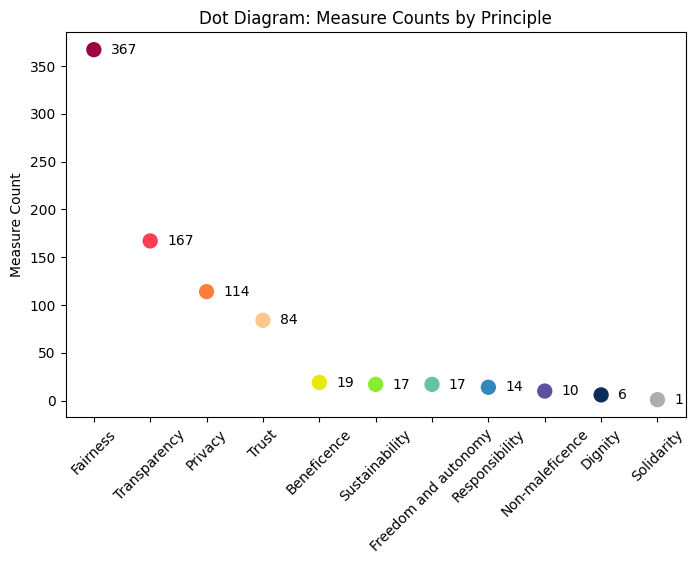

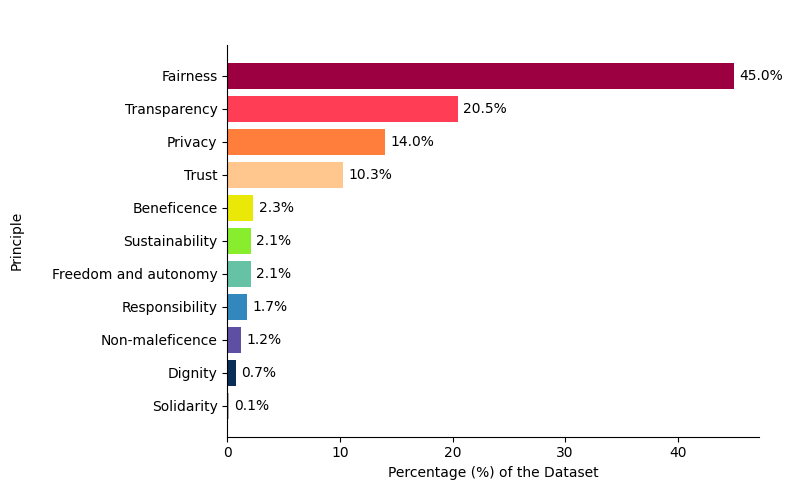

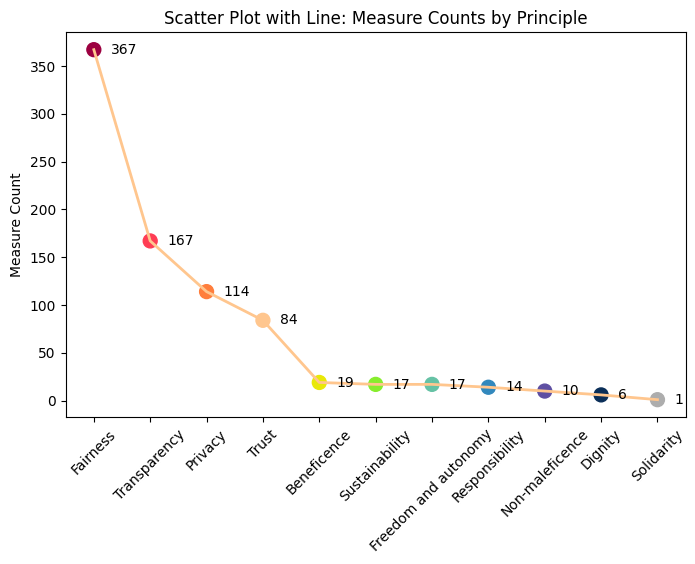

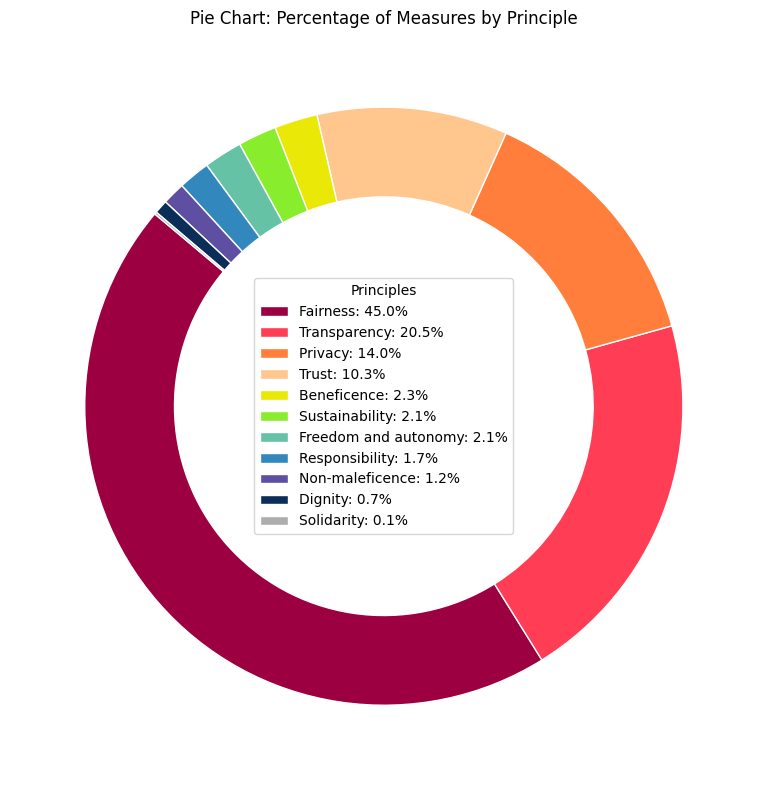

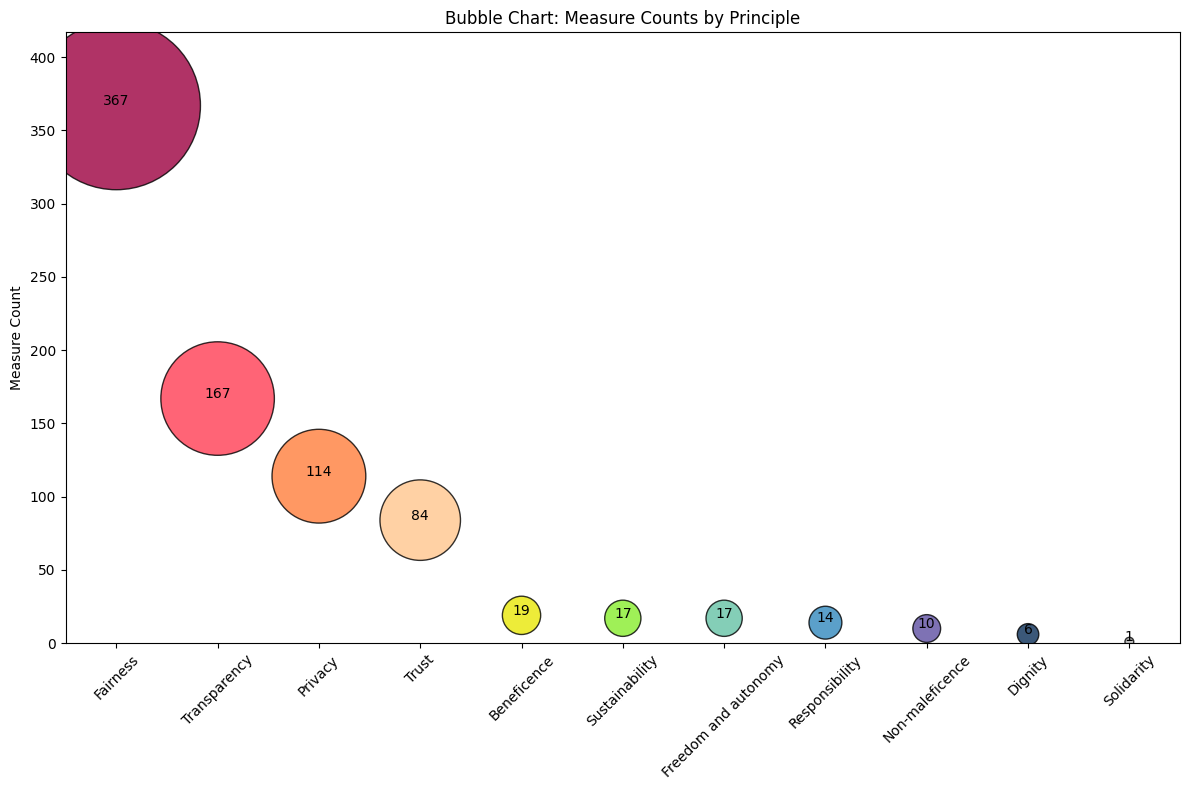

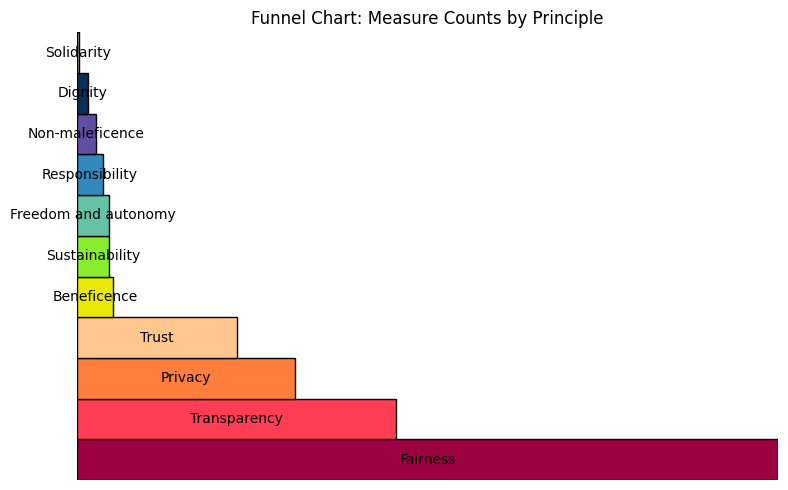

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Custom color palette
custom_palette_updated = [
    "#9c0040", "#ff3d54", "#ff7e3c", "#ffc68e", "#e9e807",  # Replaced two colors for higher contrast
    "#87ed2d", "#66c2a5", "#3288bd", "#5e4fa2", "#0a2e58",
    "#adadad"
]

# Sort data by Measure Count descending
measures_count_df = measures_count_df.sort_values(by='Measure Count', ascending=False)

# Calculate percentage share
total_measures = measures_count_df['Measure Count'].sum()
measures_count_df['Percentage'] = (measures_count_df['Measure Count'] / total_measures) * 100

### VISUALIZATIONS ###

# Dot Diagram with Counts Shifted Right
plt.figure(figsize=(8, 5))
plt.scatter(range(len(measures_count_df['Principle'])), measures_count_df['Measure Count'], s=100, color=custom_palette_updated[:len(measures_count_df)])
for i, txt in enumerate(measures_count_df['Measure Count']):
    plt.text(i + 0.3, measures_count_df['Measure Count'].iloc[i], str(txt), ha='left', va='center', fontsize=10)
plt.xticks(range(len(measures_count_df['Principle'])), measures_count_df['Principle'], rotation=45)
plt.title('Dot Diagram: Measure Counts by Principle')
plt.ylabel('Measure Count')
plt.show()

import matplotlib.pyplot as plt
import pandas as pd

# Horizontal Bar Chart with Percentages Displayed
plt.figure(figsize=(8, 5))
plt.barh(measures_count_df['Principle'], measures_count_df['Percentage'], color=custom_palette_updated[:len(measures_count_df)])
for i, v in enumerate(measures_count_df['Percentage']):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')  # Display percentage

# Customize axes and spacing
plt.title(' ', pad=15)
plt.xlabel('Percentage (%) of the Dataset')
plt.ylabel('Principle', labelpad=20)  # Add spacing to y-axis label
plt.gca().invert_yaxis()  # Ensure the highest percentage is at the top

# Remove the box, keeping only x and y axes
ax = plt.gca()
ax.spines['top'].set_visible(False)  # Hide top spine
ax.spines['right'].set_visible(False)  # Hide right spine
ax.spines['left'].set_visible(True)  # Keep left spine
ax.spines['bottom'].set_visible(True)  # Keep bottom spine

plt.tight_layout()
plt.savefig('principle_horiz.png', dpi=300, bbox_inches='tight')
plt.show()


# Scatter Plot with Line and Counts Shifted Right
plt.figure(figsize=(8, 5))
plt.scatter(range(len(measures_count_df['Principle'])), measures_count_df['Measure Count'], s=100, color=custom_palette_updated[:len(measures_count_df)])
plt.plot(range(len(measures_count_df['Principle'])), measures_count_df['Measure Count'], '-', linewidth=2, color=custom_palette_updated[3])
for i, txt in enumerate(measures_count_df['Measure Count']):
    plt.text(i + 0.3, measures_count_df['Measure Count'].iloc[i], str(txt), ha='left', va='center', fontsize=10)
plt.xticks(range(len(measures_count_df['Principle'])), measures_count_df['Principle'], rotation=45)
plt.title('Scatter Plot with Line: Measure Counts by Principle')
plt.ylabel('Measure Count')
plt.show()

# Pie Chart with Percentages in Centered Legend
plt.figure(figsize=(8, 8))
wedges, _, autotexts = plt.pie(
    measures_count_df['Measure Count'],
    startangle=140,
    colors=custom_palette_updated[:len(measures_count_df)],
    wedgeprops=dict(width=0.3, edgecolor='w'),
    autopct=''
)
legend_labels = [f"{principle}: {percentage:.1f}%" for principle, percentage in zip(measures_count_df['Principle'], measures_count_df['Percentage'])]
plt.legend(wedges, legend_labels, title="Principles", loc="center", bbox_to_anchor=(0.5, 0.5))
plt.title('Pie Chart: Percentage of Measures by Principle')
plt.tight_layout()
plt.show()

# Bubble Chart with Counts Adjusted and Y-Axis Extended
plt.figure(figsize=(12, 8))
bubble_size = measures_count_df['Measure Count'] * 40  # Adjust bubble size
plt.scatter(
    range(len(measures_count_df['Principle'])),
    measures_count_df['Measure Count'],
    s=bubble_size,
    alpha=0.8,
    color=custom_palette_updated[:len(measures_count_df)],
    edgecolors="k")

# Adjust position of counts to avoid overlap
for i, txt in enumerate(measures_count_df['Measure Count']):
    plt.text(i, measures_count_df['Measure Count'].iloc[i] + 3, str(txt), ha='center', va='center', fontsize=10)

plt.xticks(range(len(measures_count_df['Principle'])), measures_count_df['Principle'], rotation=45)
plt.title('Bubble Chart: Measure Counts by Principle')
plt.ylabel('Measure Count')
plt.ylim(0, measures_count_df['Measure Count'].max() + 50)  # Extend y-axis to avoid cut-off
plt.tight_layout()
plt.show()

# Funnel Chart
from matplotlib.patches import Polygon

# Funnel Data
funnel_levels = measures_count_df.sort_values(by='Measure Count', ascending=False)
funnel_widths = funnel_levels['Measure Count'].values

# Create Funnel
fig, ax = plt.subplots(figsize=(8, 5))
height = 1.0  # Height of each funnel level
start_width = max(funnel_widths)  # Starting width

for i, width in enumerate(funnel_widths):
    top_left = [0, i * height]
    top_right = [width, i * height]
    bottom_left = [0, (i + 1) * height]
    bottom_right = [width, (i + 1) * height]
    polygon = Polygon([top_left, top_right, bottom_right, bottom_left], closed=True, facecolor=custom_palette_updated[i % len(custom_palette_updated)], edgecolor='black')
    ax.add_patch(polygon)
    ax.text(width / 2, i * height + height / 2, funnel_levels['Principle'].iloc[i], ha='center', va='center', fontsize=10)

ax.set_xlim(0, start_width)
ax.set_ylim(0, len(funnel_widths) * height)
ax.set_title('Funnel Chart: Measure Counts by Principle')
ax.axis('off')
plt.tight_layout()
plt.show()




## Pipeline Stage


In [ ]:
'''
SECTION: UNIQUE ML STAGES

Purpose:
-List all unique pipeline stages

'''

#List all pipeline stages

display(dropped_df["Component of the ML System"].unique())
dropped_df.columns

array(['Model', 'Interaction (user-output)', 'Model, Output',
       'Data/input', 'Model, Output, Interaction (user-output)', 'Output',
       'Full system', 'Data/input, Model', 'Output, Model',
       'Output, Interaction (user-output)',
       'Interaction (user-output), Full system',
       'Interaction (user-output), Data/input, Full system',
       'Data/input, Output', 'Model, Data/input',
       'Interaction (user-output), Data/input',
       'Model, Interaction (user-output)',
       'Interaction (user-output), Output', 'Model, Full system',
       'Output , Model', 'Full system, Model',
       'Output , Interaction (user-output)', 'Data/input, Model, Output'],
      dtype=object)

Index(['Measure', 'Measurement Process', 'Principle', 'Component of the ML System', 'Criterion Name', 'Criterion Description', 'Type of Assessment', 'Application Area', 'Purpose of ML System', 'Type of Data', 'Algorithm Type', 'Title', 'Lead Author(s)', 'Publication Year', 'Key Contributions'], dtype='object')

In [ ]:
'''
SECTION: STATS OF UNIQUE ML STAGES (E.G. NO COMBINATIONS)

Purpose:
-List proportions of all unique ML stages

'''

 ### TEST: CONFIRMED THE FULL SYSTEM COUNT ###

dropped_df_stage = dropped_df.copy()

#Split the 'Component of the ML System' column by commas to handle multiple entries
dropped_df_stage['Component of the ML System'] = dropped_df_stage['Component of the ML System'].str.split(',')

#Clean up spaces and lowercase each part after splitting
dropped_df_stage['Component of the ML System'] = dropped_df_stage['Component of the ML System'].apply(
    lambda x: [item.strip().lower() for item in x] if isinstance(x, list) else x
)

#Explode the 'Component of the ML System' column
dropped_df_stage_ex = dropped_df_stage.explode('Component of the ML System')

#Count the occurrences of each unique stage of the ML system
stage_counts = dropped_df_stage_ex['Component of the ML System'].value_counts().reset_index()

stage_counts.columns = ['Component of the ML System', 'Count']

#Calculate the percentage of the dataset for each stage
total_stages = len(dropped_df_stage_ex)
stage_counts['Percentage'] = (stage_counts['Count'] / total_stages) * 100

display(stage_counts.head(5))


,Component of the ML System,Count,Percentage
0,model,453,39.632546
1,output,337,29.483815
2,interaction (user-output),201,17.585302
3,data/input,128,11.198600
4,full system,24,2.099738


In [ ]:
'''
SECTION: STATS OF COMBINED PIPELINE STAGES

Purpose:
-List the proportions of all combined pipeline stages

'''

### TEST: CONFIRMED OUTPUT AND DATA/INPUT & MODEL (CUMULATIVELY ADDED IN THE TABLE) COUNTS ###

dropped_df_stage = dropped_df.copy()

#Clean the 'Part of the ML System' column by stripping leading/trailing spaces and converting to lowercase
dropped_df_stage['Component of the ML System'] = dropped_df_stage['Component of the ML System'].apply(
    lambda x: sorted([item.strip().lower() for item in x.split(',')]) if isinstance(x, str) else x
)

#Join the sorted parts back into a single string
dropped_df_stage['Component of the ML System'] = dropped_df_stage['Component of the ML System'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)

#Count the occurrences of each unique ML stage
stage_counts = dropped_df_stage['Component of the ML System'].value_counts().reset_index()

#Rename columns
stage_counts.columns = ['Component of the ML System', 'Count']

#Calculate the percentage
total_stage = len(dropped_df_stage)
stage_counts['Percentage'] = (stage_counts['Count'] / total_stage) * 100

print(stage_counts)


                            Component of the ML System  Count  Percentage
0                                        model, output    290   36.662453
1                            interaction (user-output)    180   22.756005
2                                                model    129   16.308470
3                                           data/input     93   11.757269
4                                               output     25    3.160556
5                                    data/input, model     21    2.654867
6                                          full system     17    2.149178
7                                   data/input, output     10    1.264223
8                    interaction (user-output), output      8    1.011378
9                     interaction (user-output), model      6    0.758534
10                                  full system, model      3    0.379267
11              full system, interaction (user-output)      3    0.379267
12            interaction (user-output

# Application Area

In [ ]:
'''
SECTION: STATS OF UNIQUE ML STAGES (E.G. NO COMBINATIONS)

Purpose:
-List proportions of all unique ML stages

'''

 ### TEST: CONFIRMED THE FULL SYSTEM COUNT ###

print("Total rows in dropped_df:", len(dropped_df))

dropped_df_aa = dropped_df.copy()

#Split the 'Component of the ML System' column by commas to handle multiple entries
dropped_df_aa['Application Area'] = dropped_df_aa['Application Area'].str.split(',')

#Clean up spaces and lowercase each part after splitting
dropped_df_aa['Application Area'] = dropped_df_aa['Application Area'].apply(
    lambda x: [item.strip().lower() for item in x] if isinstance(x, list) else x
)

#Explode the 'Component of the ML System' column
dropped_df_aa_ex = dropped_df_aa.explode('Application Area')

#Count the occurrences of each unique stage of the ML system
aa_counts = dropped_df_aa_ex['Application Area'].value_counts().reset_index()

aa_counts.columns = ['Application Area', 'Count']

#Calculate the percentage of the dataset for each stage
total_aa = len(dropped_df_aa_ex)
aa_counts['Percentage'] = (aa_counts['Count'] / total_aa) * 100

display(aa_counts)

Total rows in dropped_df: 791


,Application Area,Count,Percentage
0,other,595,63.500534
1,healthcare,127,13.553895
2,finance,72,7.684098
3,criminal justice,46,4.909285
4,journalism,31,3.308431
5,education,23,2.454642
6,entertainment,18,1.921025
7,energy/environment,18,1.921025
8,transportation,7,0.747065


# Type of Assessment

In [ ]:
'''
SECTION: STATS OF UNIQUE ML STAGES (E.G. NO COMBINATIONS)

Purpose:
-List proportions of all unique ML stages

'''
'''
SECTION: STATS OF UNIQUE ASSESSMENT TYPES

Purpose:
-List proportions of all unique assessment types
'''


'''
SECTION: DEBUGGING UNIQUE ASSESSMENT TYPES

Purpose:
- Identify and resolve overcounting issues in the analysis of assessment types

SECTION: DEBUGGING UNIQUE ASSESSMENT TYPES

Purpose:
- Identify and resolve overcounting issues in the analysis of assessment types
'''

### ADAPTED: CONFIRMED TYPE OF ASSESSMENT COUNT ###

### FINAL FIXED: Type of Assessment COUNT ###


 ### TEST: CONFIRMED THE FULL SYSTEM COUNT ###

import pandas as pd
import matplotlib.pyplot as plt

# Make sure you have your original dataframe
# dropped_df = pd.read_csv('your_file.csv')  # or however you load it

# Keep original dataframe untouched
# Work from original, unmodified dataframe
print("Total rows in original dropped_df:", len(dropped_df))

dropped_df_ta = dropped_df.copy()

# Split and clean Type of Assessment
dropped_df_ta['Type of Assessment'] = dropped_df_ta['Type of Assessment'].str.split(',')
dropped_df_ta = dropped_df_ta.explode('Type of Assessment')
dropped_df_ta['Type of Assessment'] = dropped_df_ta['Type of Assessment'].str.strip().str.lower()

# Count occurrences
ta_counts = dropped_df_ta['Type of Assessment'].value_counts().reset_index()
ta_counts.columns = ['Type of Assessment', 'Count']

# Calculate percentages
total_ta = ta_counts['Count'].sum()
ta_counts['Percentage'] = (ta_counts['Count'] / total_ta) * 100

display(ta_counts)


Total rows in original dropped_df: 791


,Type of Assessment,Count,Percentage
0,mathematical,315,39.672544
1,statistical,291,36.649874
2,self-reported,137,17.254408
3,behavioural,51,6.423174



--- Raw exploded Type of Assessment counts (no grouping) ---
Type of Assessment
Mathematical     321
Statistical      300
Self-reported    145
Behavioural       51
Name: count, dtype: int64

--- Grouped counts before pivot ---
               Principle Type of Assessment  count
0            Beneficence        Behavioural      4
1            Beneficence       Mathematical      4
2            Beneficence      Self-reported     11
3                Dignity      Self-reported      6
4               Fairness        Behavioural      7
5               Fairness       Mathematical    125
6               Fairness      Self-reported     15
7               Fairness        Statistical    221
8   Freedom and autonomy        Behavioural      1
9   Freedom and autonomy      Self-reported     16
10       Non-maleficence       Mathematical      3
11       Non-maleficence      Self-reported      2
12       Non-maleficence        Statistical      5
13               Privacy        Behavioural      1
14     

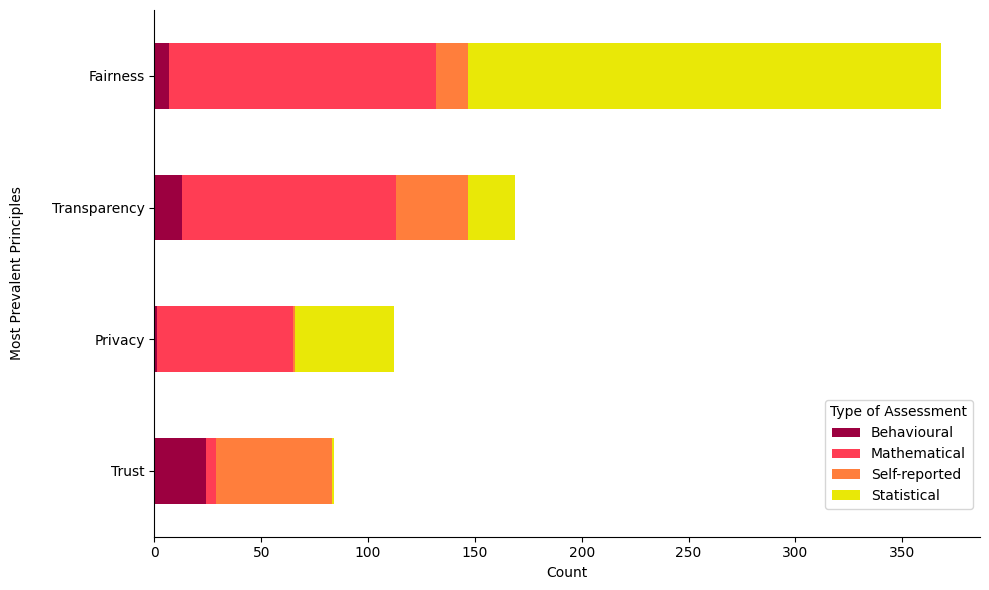

In [ ]:
for col in ['Principle', 'Type of Assessment']:
    dropped_df[col] = dropped_df[col].apply(lambda x: str(x) if isinstance(x, list) else x)

# Explode columns if they contain multiple values (e.g., comma-separated lists)
for col in ['Principle', 'Type of Assessment']:
    if dropped_df[col].apply(lambda x: isinstance(x, str) and ',' in x).any():
        dropped_df[col] = dropped_df[col].str.split(',')
        dropped_df = dropped_df.explode(col).reset_index(drop=True)

# Strip whitespace for clean grouping
dropped_df['Principle'] = dropped_df['Principle'].str.strip()
dropped_df['Type of Assessment'] = dropped_df['Type of Assessment'].str.strip()

print("\n--- Raw exploded Type of Assessment counts (no grouping) ---")
print(dropped_df['Type of Assessment'].value_counts())

# Group by Principle and Type of Assessment, and count occurrences
grouped_all = dropped_df.groupby(['Principle', 'Type of Assessment']).size().reset_index(name='count')

# Create the pivot table: 'Principle' as rows, 'Type of Assessment' as columns
pivot_table = grouped_all.pivot_table(index='Principle', columns='Type of Assessment', values='count', fill_value=0)

# Plotting the horizontal stacked bar chart
custom_palette = [
    "#9c0040", "#ff3d54", "#ff7e3c", "#e9e807", "#ffc68e", "#e9e807",
    "#87ed2d", "#66c2a5", "#3288bd", "#5e4fa2", "#0a2e58",
    "#adadad"
]

# Filter specific principles for plotting
filtered_data = pivot_table.loc[["Fairness", "Transparency", "Trust", "Privacy"]]

# Sort principles in reverse order by total count (highest first)
filtered_data['Total'] = filtered_data.sum(axis=1)  # Add a column for total counts
filtered_data = filtered_data.sort_values(by='Total', ascending=True).drop(columns='Total')

print("\n--- Grouped counts before pivot ---")
print(grouped_all)

print("\n--- Pivot table (Principle x Type of Assessment) ---")
print(pivot_table)

print("\n--- Total counts per Principle ---")
print(pivot_table.sum(axis=1))

print("\n--- Total counts per Type of Assessment ---")
print(pivot_table.sum(axis=0))

overall_total = pivot_table.values.sum()
print("\n--- Overall total count ---")
print(overall_total)



# Plotting the horizontal stacked bar chart
ax = filtered_data.plot(
    kind='barh',  # Horizontal bar chart
    stacked=True,
    figsize=(10, 6),
    color=custom_palette[:len(filtered_data.columns)]
)

# Customizing the plot
# plt.title('Count of Selected Principles by Type of Assessment')
plt.ylabel('Most Prevalent Principles', labelpad=20)  # Move title farther left with labelpad
plt.xlabel('Count')
plt.xticks(rotation=0)  # No rotation needed for horizontal bars

# Remove the box, keeping only x and y axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(
    title="Type of Assessment",
    bbox_to_anchor=(1.0, 0.04),  # Bottom-right position
    loc='lower right',  # Legend aligned to the bottom-right
    ncol=1  # Legend displayed in a single column
)
plt.tight_layout()
plt.savefig('type_ass.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparative Stats

---

## Pivot Table: Pivot Table Comparison of Principles and ML Stages

In [ ]:
'''
SECTION: GENERATE PIVOT TABLE

Purpose:
-Create a pivot table of all principles and parts of the ML system

'''

import pandas as pd

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Convert list entries to strings
for col in ['Principle', 'Component of the ML System']:
    dropped_df[col] = dropped_df[col].apply(lambda x: str(x) if isinstance(x, list) else x)

#Explode columns if they contain multiple values (e.g., comma-separated lists)
for col in ['Principle', 'Component of the ML System']:
    if dropped_df[col].apply(lambda x: isinstance(x, str) and ',' in x).any():
        dropped_df[col] = dropped_df[col].str.split(',')
        dropped_df = dropped_df.explode(col).reset_index(drop=True)

#Strip whitespace for clean grouping
dropped_df['Principle'] = dropped_df['Principle'].str.strip()
dropped_df['Component of the ML System'] = dropped_df['Component of the ML System'].str.strip()

#Group by Principle and Part of the ML System, and count occurrences
grouped_all = dropped_df.groupby(['Principle', 'Component of the ML System']).size().reset_index(name='count')

#Create the pivot table: 'Principle' as rows, 'Part of the ML System' as columns
pivot_table = grouped_all.pivot_table(index='Principle', columns='Component of the ML System', values='count', fill_value=0)

display(pivot_table)


Component of the ML System,Data/input,Full system,Interaction (user-output),Model,Output
Principle,,,,,
Beneficence,0.0,0.0,15.0,6.0,4.0
Dignity,0.0,0.0,6.0,0.0,0.0
Fairness,44.0,4.0,24.0,298.0,262.0
Freedom and autonomy,0.0,0.0,17.0,0.0,0.0
Non-maleficence,5.0,0.0,2.0,4.0,3.0
Privacy,71.0,0.0,1.0,42.0,11.0
Responsibility,5.0,0.0,8.0,1.0,0.0
Solidarity,0.0,0.0,1.0,0.0,0.0
Sustainability,0.0,15.0,0.0,5.0,0.0


In [ ]:
'''
SECTION: COUNT PRINCIPLES AND PARTS OF THE ML SYSTEM

Purpose:
-Count all principles and parts of the ML system

'''

import pandas as pd

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Convert list entries to strings
for col in ['Principle', 'Component of the ML System']:
    dropped_df[col] = dropped_df[col].apply(lambda x: str(x) if isinstance(x, list) else x)

#Explode columns if they contain multiple values (e.g., comma-separated lists)
for col in ['Principle', 'Component of the ML System']:
    if dropped_df[col].apply(lambda x: isinstance(x, str) and ',' in x).any():
        dropped_df[col] = dropped_df[col].str.split(',')
        dropped_df = dropped_df.explode(col).reset_index(drop=True)

#Strip whitespace for clean grouping
dropped_df['Principle'] = dropped_df['Principle'].str.strip()
dropped_df['Component of the ML System'] = dropped_df['Component of the ML System'].str.strip()

#Group by principle and part of the ML system and count occurrences
grouped_all = dropped_df.groupby(['Principle', 'Component of the ML System']).size().reset_index(name='count')

#Create the pivot table - 'Principle' as rows and 'Part of the ML System' as columns
pivot_table = grouped_all.pivot_table(index='Principle', columns='Component of the ML System', values='count', fill_value=0)

#Calculate percentages within each principle
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
pivot_table_percentage = pivot_table_percentage.round(2)

print("Count Table:")
display(pivot_table)
print("\nPercentage Table (within each Principle, rounded to 2 decimal places):")
display(pivot_table_percentage)



Count Table:


Component of the ML System,Data/input,Full system,Interaction (user-output),Model,Output
Principle,,,,,
Beneficence,0.0,0.0,15.0,6.0,4.0
Dignity,0.0,0.0,6.0,0.0,0.0
Fairness,44.0,4.0,24.0,298.0,262.0
Freedom and autonomy,0.0,0.0,17.0,0.0,0.0
Non-maleficence,5.0,0.0,2.0,4.0,3.0
Privacy,71.0,0.0,1.0,42.0,11.0
Responsibility,5.0,0.0,8.0,1.0,0.0
Solidarity,0.0,0.0,1.0,0.0,0.0
Sustainability,0.0,15.0,0.0,5.0,0.0



Percentage Table (within each Principle, rounded to 2 decimal places):


Component of the ML System,Data/input,Full system,Interaction (user-output),Model,Output
Principle,,,,,
Beneficence,0.00,0.00,60.00,24.00,16.00
Dignity,0.00,0.00,100.00,0.00,0.00
Fairness,6.96,0.63,3.80,47.15,41.46
Freedom and autonomy,0.00,0.00,100.00,0.00,0.00
Non-maleficence,35.71,0.00,14.29,28.57,21.43
Privacy,56.80,0.00,0.80,33.60,8.80
Responsibility,35.71,0.00,57.14,7.14,0.00
Solidarity,0.00,0.00,100.00,0.00,0.00
Sustainability,0.00,75.00,0.00,25.00,0.00


In [ ]:
#Total dataset

#Calculate the overall percentage of each count in the pivot table
total_count = pivot_table.values.sum()
pivot_table_total_percentage = (pivot_table / total_count * 100).round(2)

print("Count Table:")
display(pivot_table)
print("\nPercentage Table (of total counts, rounded to 2 decimal places):")
display(pivot_table_total_percentage)


Count Table:


Component of the ML System,Data/input,Full system,Interaction (user-output),Model,Output
Principle,,,,,
Beneficence,0.0,0.0,15.0,6.0,4.0
Dignity,0.0,0.0,6.0,0.0,0.0
Fairness,44.0,4.0,24.0,298.0,262.0
Freedom and autonomy,0.0,0.0,17.0,0.0,0.0
Non-maleficence,5.0,0.0,2.0,4.0,3.0
Privacy,71.0,0.0,1.0,42.0,11.0
Responsibility,5.0,0.0,8.0,1.0,0.0
Solidarity,0.0,0.0,1.0,0.0,0.0
Sustainability,0.0,15.0,0.0,5.0,0.0



Percentage Table (of total counts, rounded to 2 decimal places):


Component of the ML System,Data/input,Full system,Interaction (user-output),Model,Output
Principle,,,,,
Beneficence,0.00,0.00,1.28,0.51,0.34
Dignity,0.00,0.00,0.51,0.00,0.00
Fairness,3.75,0.34,2.04,25.38,22.32
Freedom and autonomy,0.00,0.00,1.45,0.00,0.00
Non-maleficence,0.43,0.00,0.17,0.34,0.26
Privacy,6.05,0.00,0.09,3.58,0.94
Responsibility,0.43,0.00,0.68,0.09,0.00
Solidarity,0.00,0.00,0.09,0.00,0.00
Sustainability,0.00,1.28,0.00,0.43,0.00


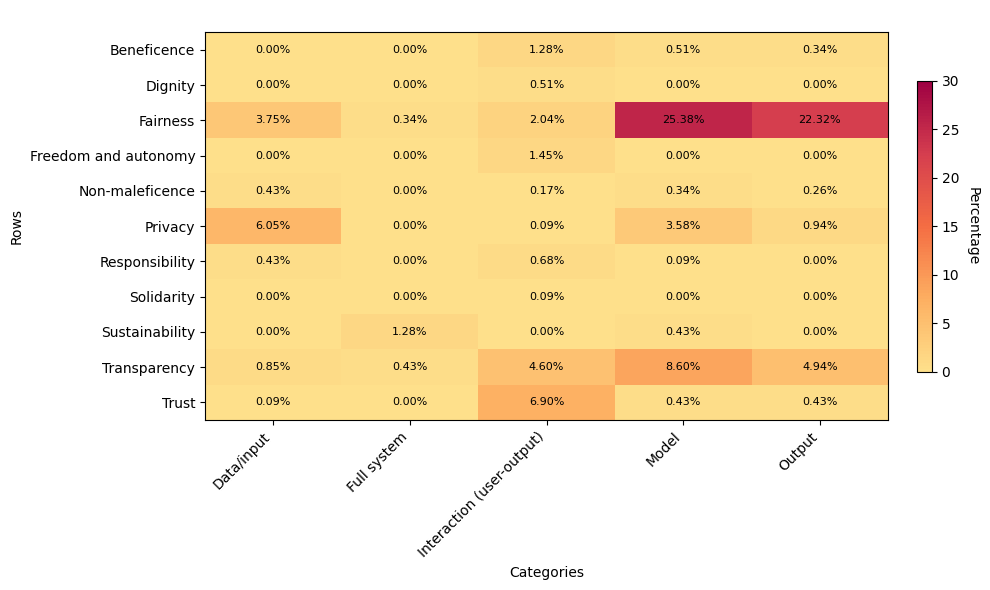

In [ ]:
'''
SECTION: CREATE HEATMAP

Purpose:
-Show the heatmap between the principles and parts of the ML system

'''

from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

custom_palette_adjusted = [
    "#fee08b", "#fdae61", "#f46d43", "#d53e4f", "#9e0142"
]

# Create a colour map from the adjusted colour palette
custom_cmap_adjusted = LinearSegmentedColormap.from_list("custom_ombre_adjusted", custom_palette_adjusted, N=100)

#Due to the small percentages, only have a limited range (0 to 30)
def create_adjusted_heatmap():
    fig, ax = plt.subplots(figsize=(10, 6))

    #Create the heatmap
    heatmap = ax.imshow(
        pivot_table_total_percentage,
        cmap=custom_cmap_adjusted,
        interpolation='nearest',
        aspect='auto',
        vmin=0, vmax=30  #Limit the range to 0 to 30
    )

    #Add colour bar
    cbar = plt.colorbar(heatmap, ax=ax, fraction=0.02, pad=0.04, ticks=range(0, 31, 5))
    cbar.set_label('Percentage', rotation=270, labelpad=15)

    ax.set_xticks(np.arange(len(pivot_table.columns)))
    ax.set_yticks(np.arange(len(pivot_table.index)))
    ax.set_xticklabels(pivot_table.columns, rotation=45, ha='right')
    ax.set_yticklabels(pivot_table.index)

    #Annotate each cell with percentage value
    for i in range(len(pivot_table_total_percentage.index)):
        for j in range(len(pivot_table_total_percentage.columns)):
            percentage = pivot_table_total_percentage.iloc[i, j]
            ax.text(j, i, f"{percentage:.2f}%", ha="center", va="center", color="black", fontsize=8)

    ax.set_title(" ")
    ax.set_xlabel("Categories")
    ax.set_ylabel("Rows")

    plt.tight_layout()
    plt.show()

#Call the function to display
create_adjusted_heatmap()

In [ ]:
'''
SECTION: GROUP THE DATASET BY PRINCIPLE, ALL HARMS, AND THE ML PIPELINE STAGE

Purpose:
-Group the pivot table columns based on entry points

'''

import pandas as pd

#Show full display
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Convert list entries to strings for grouping
for col in ['Principle', 'Component of the ML System']:
    dropped_df[col] = dropped_df[col].apply(lambda x: str(x) if isinstance(x, list) else x)

#Group by 'Principle' and 'Part of the ML System', count occurrences
grouped_all = dropped_df.groupby(['Principle', 'Component of the ML System']).size().reset_index(name='count')

#Create the pivot table
pivot_table = grouped_all.pivot_table(index='Principle', columns='Component of the ML System', values='count', fill_value=0)

display(pivot_table)


Component of the ML System,Data/input,Full system,Interaction (user-output),Model,Output
Principle,,,,,
Beneficence,0.0,0.0,15.0,6.0,4.0
Dignity,0.0,0.0,6.0,0.0,0.0
Fairness,44.0,4.0,24.0,298.0,262.0
Freedom and autonomy,0.0,0.0,17.0,0.0,0.0
Non-maleficence,5.0,0.0,2.0,4.0,3.0
Privacy,71.0,0.0,1.0,42.0,11.0
Responsibility,5.0,0.0,8.0,1.0,0.0
Solidarity,0.0,0.0,1.0,0.0,0.0
Sustainability,0.0,15.0,0.0,5.0,0.0


In [ ]:
#Create pivot table

pivot_principle_stage = grouped_all.pivot_table(index='Principle', columns='Component of the ML System', values='count')
print("\nPivot table for count of each Principle and Component of the ML System:")
print(pivot_principle_stage)



Pivot table for count of each Principle and Component of the ML System:
Component of the ML System  Data/input  Full system  Interaction (user-output)  Model  Output
Principle                                                                                    
Beneficence                        NaN          NaN                       15.0    6.0     4.0
Dignity                            NaN          NaN                        6.0    NaN     NaN
Fairness                          44.0          4.0                       24.0  298.0   262.0
Freedom and autonomy               NaN          NaN                       17.0    NaN     NaN
Non-maleficence                    5.0          NaN                        2.0    4.0     3.0
Privacy                           71.0          NaN                        1.0   42.0    11.0
Responsibility                     5.0          NaN                        8.0    1.0     NaN
Solidarity                         NaN          NaN                        1.0   

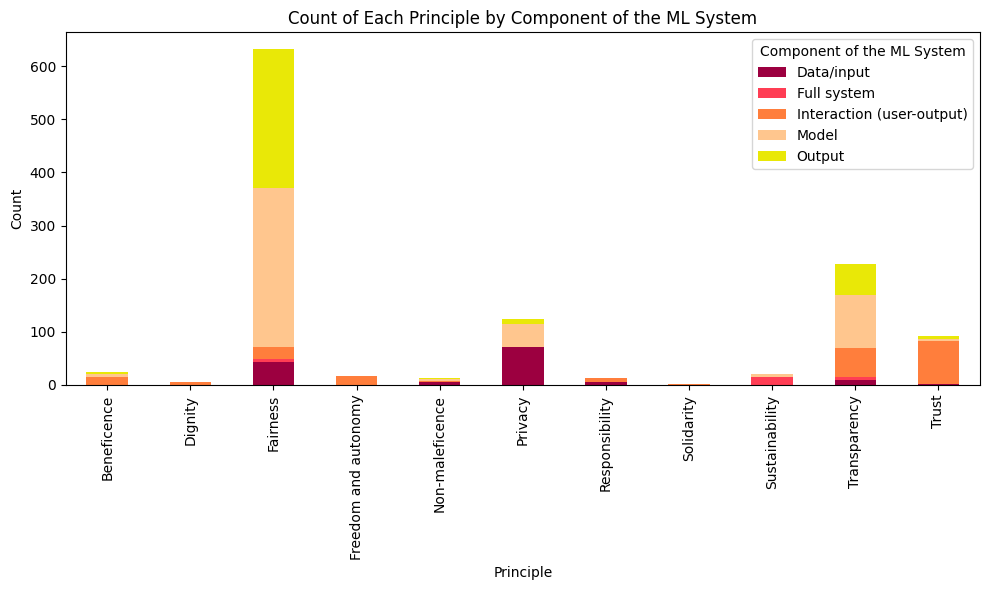

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

custom_palette= [
    "#9c0040", "#ff3d54", "#ff7e3c", "#ffc68e", "#e9e807",  # Replaced two colors for higher contrast
    "#87ed2d", "#66c2a5", "#3288bd", "#5e4fa2", "#0a2e58",
    "#adadad"
]

pivot_principle_stage = grouped_all.pivot_table(
    index='Principle',
    columns='Component of the ML System',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Plotting a stacked bar chart
pivot_principle_stage.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=custom_palette[:len(pivot_principle_stage.columns)]
)
plt.title('Count of Each Principle by Component of the ML System')
plt.xlabel('Principle')
plt.ylabel('Count')
plt.legend(title='Component of the ML System')
plt.tight_layout()

plt.show()

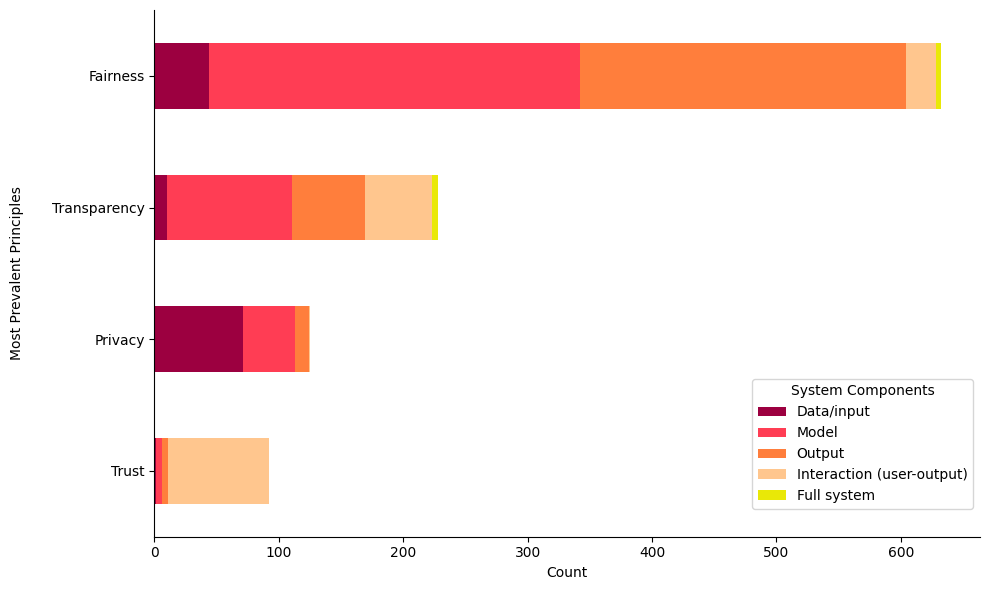

In [ ]:
# Reorder the columns in the desired sequence
import pandas as pd
import matplotlib.pyplot as plt

# Custom palette (11 colors total, but we'll use only the first 5)
custom_palette_updated = [
    "#9c0040", "#ff3d54", "#ff7e3c", "#ffc68e", "#e9e807",
    "#87ed2d", "#66c2a5", "#3288bd", "#5e4fa2", "#0a2e58",
    "#adadad"
]

# Pivot the original grouped DataFrame
pivot_principle_stage = grouped_all.pivot_table(
    index='Principle',
    columns='Component of the ML System',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Filter only selected principles
filtered_data = pivot_principle_stage.loc[["Fairness", "Transparency", "Trust", "Privacy"]]

# Add total column for sorting
filtered_data['Total'] = filtered_data.sum(axis=1)

# Sort by total and drop total column
filtered_data = filtered_data.sort_values(by='Total', ascending=True).drop(columns='Total')

# Reorder columns (components) to desired order
desired_order = ["Data/input", "Model", "Output", "Interaction (user-output)", "Full system"]
filtered_data = filtered_data[desired_order]

# Plotting horizontal stacked bar chart
ax = filtered_data.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=custom_palette_updated[:len(desired_order)]
)

# Customize plot
# plt.title('Count of Selected Principles by Component of the ML System')
plt.ylabel('Most Prevalent Principles', labelpad=20)
plt.xlabel('Count')
plt.xticks(rotation=0)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
plt.legend(
    title="System Components",
    bbox_to_anchor=(1.0, 0.04),
    loc='lower right',
    ncol=1
)

# Final layout adjustment and display
plt.tight_layout()
plt.savefig('sys_comp.png', dpi=300, bbox_inches='tight')
plt.show()



# Heat map

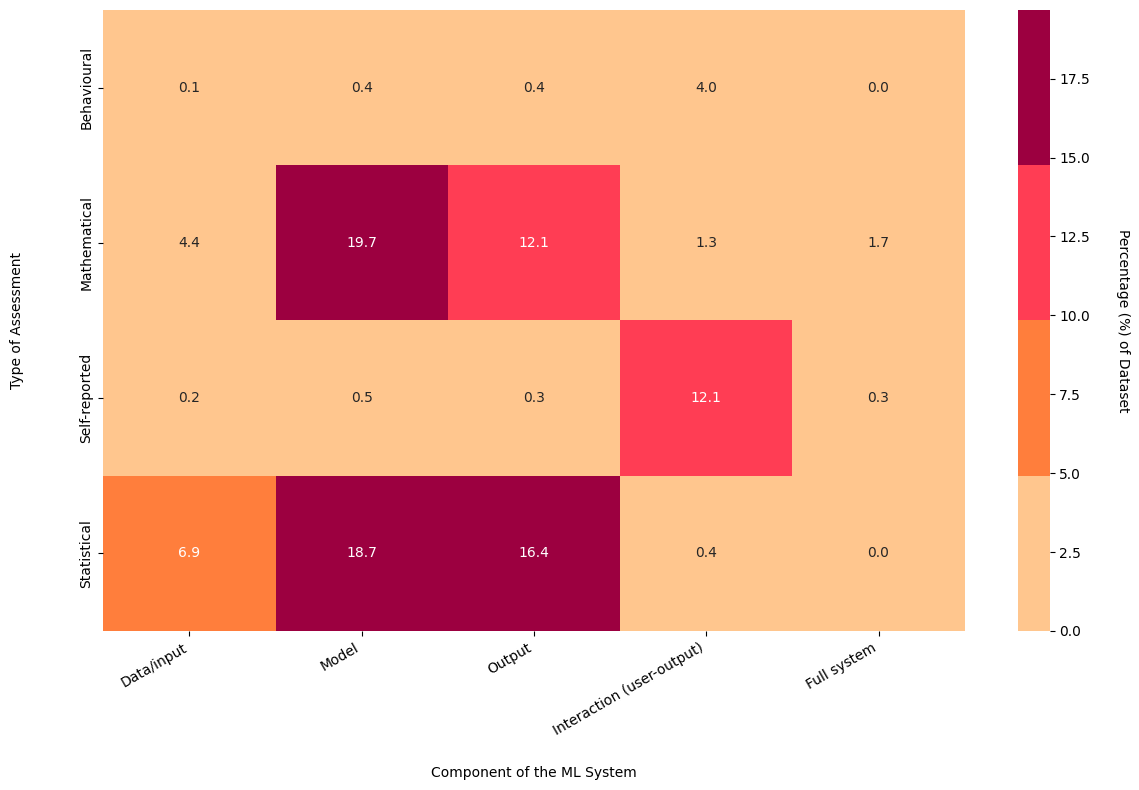

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split multi-entry columns into lists
dropped_df['Component of the ML System'] = dropped_df['Component of the ML System'].str.split(', ')
dropped_df['Type of Assessment'] = dropped_df['Type of Assessment'].str.split(', ')

# Step 2: Explode into separate rows for each combination
dropped_df_exploded = dropped_df.explode('Component of the ML System').explode('Type of Assessment')

# Step 3: Group and count
heatmap_data = dropped_df_exploded.groupby(['Type of Assessment', 'Component of the ML System']).size().reset_index(name='Count')

# Step 4: Pivot for heatmap
pivot_data = heatmap_data.pivot(index='Type of Assessment', columns='Component of the ML System', values='Count').fillna(0)

# Step 5: Reorder columns
desired_order = ["Data/input", "Model", "Output", "Interaction (user-output)", "Full system"]
pivot_data = pivot_data[desired_order]

# Step 6: Convert counts to percentages
total = pivot_data.values.sum()
pivot_data_percentage = (pivot_data / total) * 100

# Step 7: Custom color palette (reversed)
custom_palette_reduced = ["#ffc68e", "#ff7e3c", "#ff3d54", "#9c0040"]

# Step 8: Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    pivot_data_percentage,
    annot=True,
    fmt='.1f',
    cmap=sns.color_palette(custom_palette_reduced, as_cmap=True),
    cbar_kws={'label': ''}  # We'll set label manually next
)

# Step 9: Customize colorbar label (vertical, flipped direction)
colorbar = ax.collections[0].colorbar
colorbar.ax.set_ylabel('Percentage (%) of Dataset', rotation=-90, labelpad=-70)
colorbar.ax.yaxis.set_label_position('left')

# Step 10: Final plot customization
plt.title('')
plt.xlabel('Component of the ML System', labelpad=20)
plt.ylabel('Type of Assessment', labelpad=40)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


